# Migration topic modeling

In [1]:
import sys
import nltk
import re
import os
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append("../..")
from src.helpers import text_prepare
from src.plotter import visualize_wordcloud_topic_modeling
nltk.download('stopwords')
from nltk.corpus import stopwords
from gensim.corpora.dictionary import Dictionary
from gensim import corpora, models

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

/Users/celsadiaz/.pyenv/versions/3.6.2/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/celsadiaz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Use the German stopwords.
stpwrds = stopwords.words("german")
stpwrds = stpwrds + ['dass']

# We added some additional characters to avoid.
characters = [',', '.', '(', ')', '!', ';', '-', ':', '...', '"',
                "''", "``", '~http', '?', '@', '#', '/', "'",
                '&', '--', '[', ']', '=', '||', '+', '_', '..',
                '%', '|', '~', 'http',"\n","—","•","“","„","–",
                "في","שראל","россии","не","минобороны","и","в",
                "את", "$",">","*"]

# Optimized parameters for TF-IDF in the notebook "Selection of articles related to 
# migration and word frequencies exploration.ipynb" during text preprocessing
min_count = 40
max_freq = 0.5

# LDA model parameters (manually optimized)
num_topics=7
passes=5
iterations=200

### 1. Extract topics, remove duplicates and get training data ready

In [3]:
data = pd.read_csv("../../data/migration_articles.csv")
list_of_texts = data['text'].tolist()

In [4]:
def lda_model_text_processor(list_of_texts, stopwords, characters, min_count, max_freq):
    # Clean, stem and tokenize each text
    texts_clean = [text_prepare(text, stopwords, characters) for text in list_of_texts]
    
    # Trasform clean text to LDA model like format
    ldainput = [text.split() for text in texts_clean] 
    
    # Build a dictionary with each word in the texts and a unique identifier
    id2word = corpora.Dictionary(ldainput)
    
    # Apply normalization of relevant words as it will be done in TF-IDF
    # Filter out those words that appear in more than max_freq
    # Filter out those words that appear in less than min_freq
    id2word.filter_extremes(no_below=min_count, no_above=max_freq) 
    
    # Filter out those words that were not selected out of the content of the lists of texts
    # Build a bag of words representation of each doc considering only the relevant words in id2word
    ldacorpus = [id2word.doc2bow(doc) for doc in ldainput] 
    
    return id2word, ldacorpus

In [5]:
# Build LDA model input corpus, clean, tokenized, stemmed and normalized
# Build LDA model id2word dictionary out of the previous corpus
id2word, ldacorpus = lda_model_text_processor(list_of_texts, stpwrds, characters, min_count, max_freq)

# Train the model on the input corpus to learn 
lda = models.LdaModel(ldacorpus, id2word=id2word, num_topics=num_topics, passes=passes, iterations=iterations,
                      random_state=42)

### Visualization of topics after modeling

In [7]:
# Load stemmer mapping generated during TF-IDF parameters optimization and reverse stemming for wordcloud
stemming_mapper = pd.read_csv('../../data/stemming_mapper.csv')
stemming_dict = dict(zip(stemming_mapper['stem'],stemming_mapper['complete']))

In [27]:
# Build word cloud for each of the topics modeled based on the word probabilities calculated
topics = []
topic_word_representation = lda.print_topics(num_words=50)
for id, words in topic_word_representation:
    l_words = words.split(" + ")
    topic = [word.split("*") for word in l_words]
    topic = pd.DataFrame(topic).rename(columns={0:'freq',1:'word'})
    topic['freq'] = topic['freq'].astype(float)
    topic['word'] = topic['word'].apply(lambda x: re.sub('"', '', x))
    topic['word_complete'] = topic['word'].map(stemming_dict)
    topic_word_distrb = dict(zip(topic['word_complete'], topic['freq'])) 
    topics.append(topic_word_distrb)
    
# unify first two topics (eu division and austria borders)
d_1 = topics[0]
d_1.update(topics[1])
topics_ = [d_1] + topics[2:]

labels = {1:'EU Borders',2:'Right Wing',3:'EU-Turkey',4:'DE Inner Politics',5:'Asylum',
          6:'Mediterranean'}
topic_names = ['EU Borders','Right Wing','EU-Turkey','DE Inner Politics',
               'Asylum','Mediterranean']

In [43]:
import json
with open('../../topic_modeling_result.json', 'w') as fout:
    json.dump(topics_, fout)

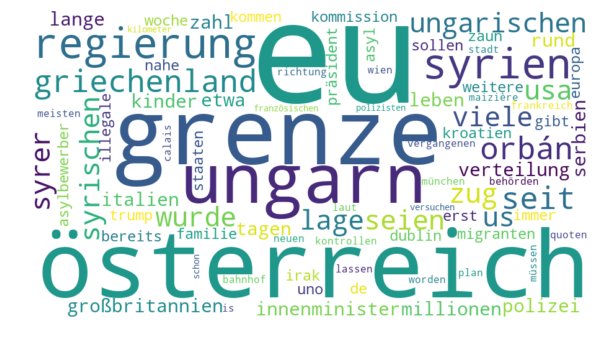

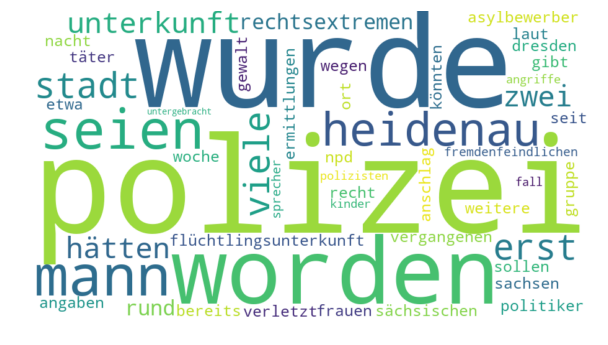

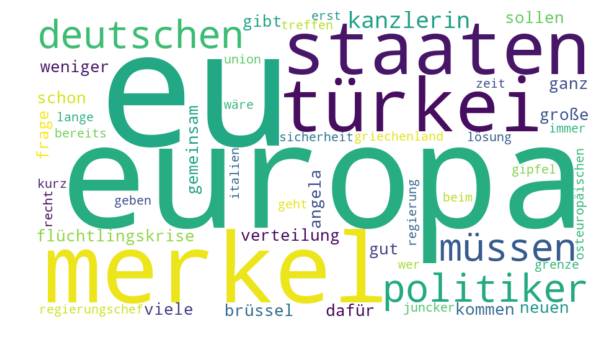

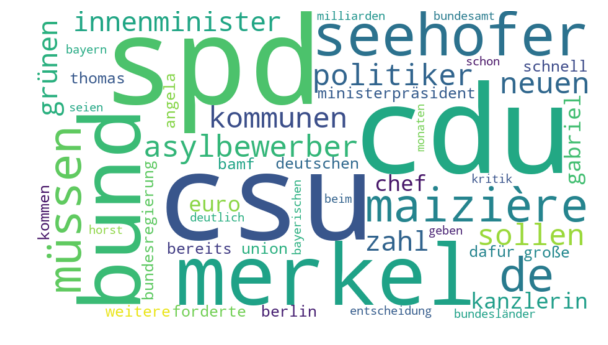

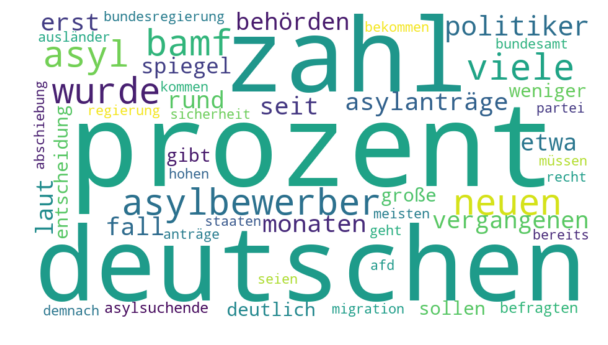

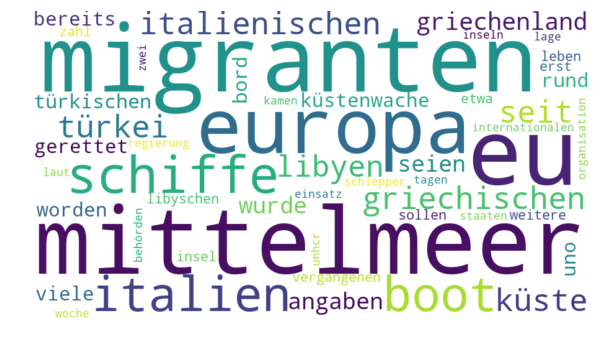

In [26]:
for i, q in enumerate(topics_):
    visualize_wordcloud_topic_modeling(q, "", 
                                       relative_scaling=0, max_words=100, background_color='white')

In [37]:
# Build dataset for plotting
# 1) infer topics in migration articles and assign the topic with higher probability to each article
arr, _ = lda.inference(ldacorpus)
data['topic'] = arr.argmax(axis=1)
data.loc[data[data['topic']==0].index,'topic'] = 1
data['label'] = data['topic'].map(labels)

# Define each x label as each month
data['date'] = data['date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))
data['month'] = data['date'].dt.strftime("%Y-%m")

# Build relative frequencies for each topic each month
agg = data.loc[:,['month','label','topic']].rename(columns={'topic':'n_topic'}).groupby(['month',
                                                        'label'], as_index=False).count()
total_agg = data.loc[:,['month','topic']].rename(columns={'topic':'n_total'}).groupby(['month'], 
                                                        as_index=False).count()
t_freqs = total_agg.merge(agg, left_on='month', right_on='month')
t_freqs['freq_topic'] = t_freqs['n_topic']/t_freqs['n_total']

In [44]:
data.to_csv('../../data/article_to_topic.csv', index=False, encoding='utf-8')
t_freqs.to_csv('../../data/article_to_topic_r.csv', index=False, encoding='utf-8')

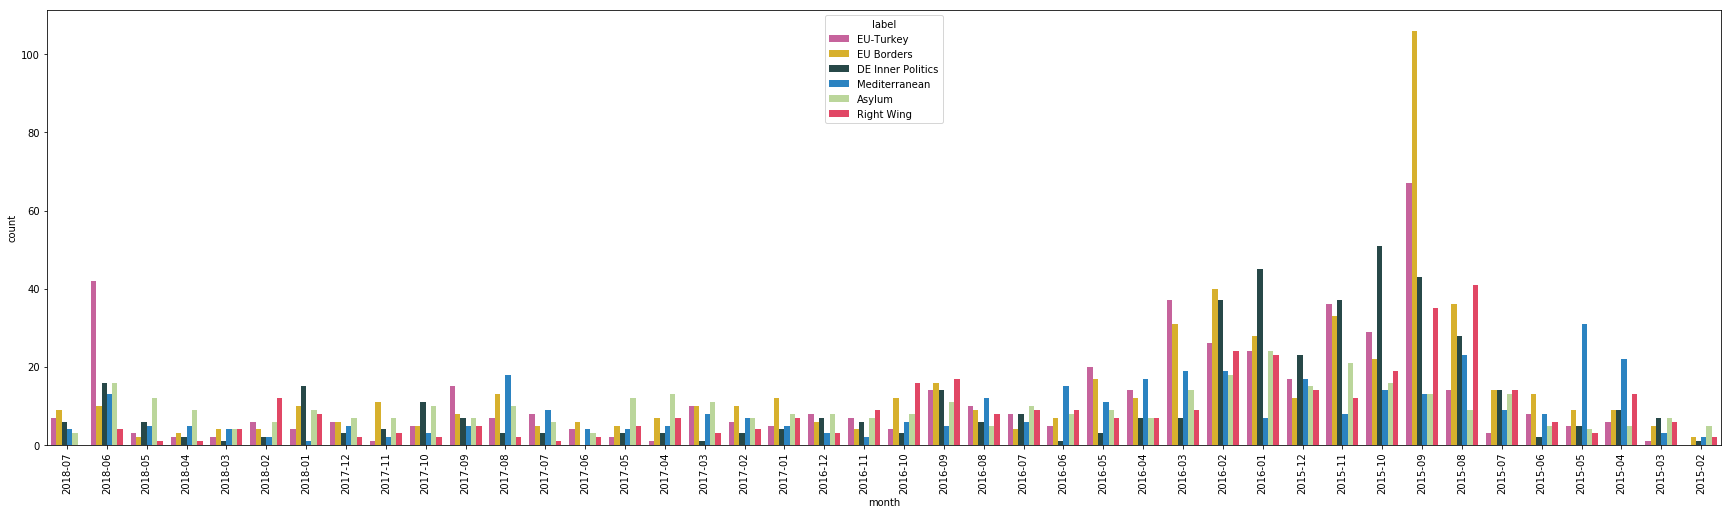

In [40]:
colors = ["#d7529f", "#f3c011", "#214d4e", "#1288da", "#bce091",'#fa2e55']
_=plt.figure(figsize=(30,8))
_=sns.countplot(x='month',data=data,hue='label',palette=colors)
_=plt.xticks(rotation=90)

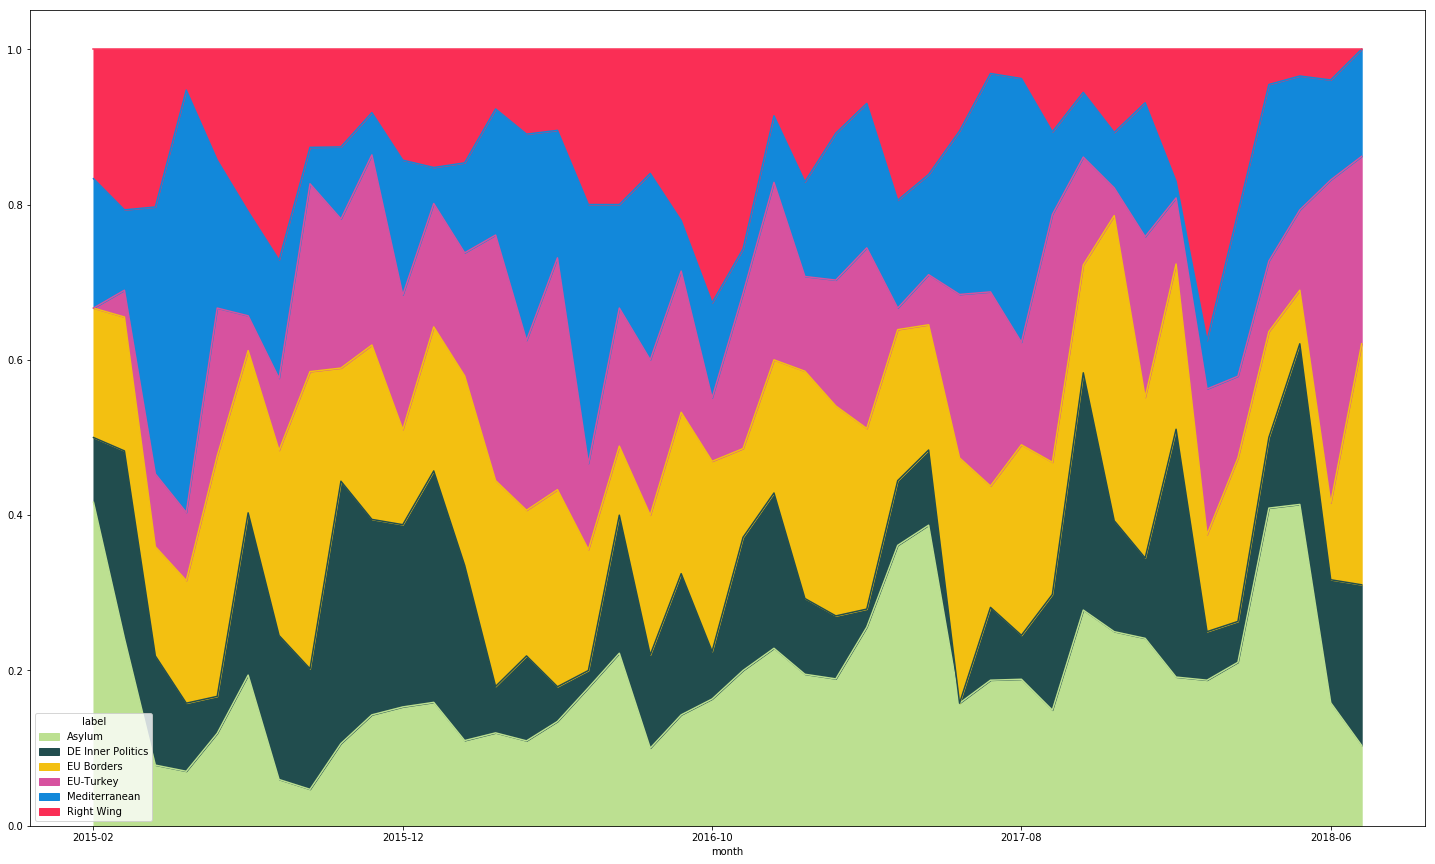

In [41]:
colors = ["#bce091", "#214d4e", "#f3c011", "#d7529f", "#1288da", '#fa2e55']
df = t_freqs.pivot(index='month', columns='label', values='freq_topic')
df.plot(kind='area', figsize=(25,15), color=colors)

### Conclusions

There are 7 clear topics:
* All related to asylum administrations and bureaucracy
* All related to the Austrian/German/Hungary border in relation to refugee control
* German inner politics regarding immigration that use to be related to CDU and CSU
* EU division pro/against walls construction against refugees (related to USA wall topic)
* EU-Turkey agreement and international relations
* All related to immigration through Mediterranean Sea
* All incidents related to recht populism or nazism

The waves of topics are correlated to the historical facts:
1. Massive flow of refugees through the Mediterranean sea
2. Rise of nazism, close of Austrian borders, EU division and EU-Turkey agreement
3. Rise of inner german politic discussion (mainly between CSU and CDU) related to refugee politics
4. Rise of topics related to how to include refugees into the system (buracracy topics)
5. Two rises of EU division, DE inner politics (CSU-CDU) and nazism around US and DE elections
6. A rise again in spring on asylum institutional topics and mediterranean sea immigration
7. Huge peack regarding EU-Turkey exactly on the Turkish elections time of 24th June 2018